In [49]:
from ietfdata.mailarchive import MailArchive
from dotenv import load_dotenv
import os
import pandas as pd
from IPython.core.display import display, HTML
import itertools
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import matplotlib.pyplot as plt
import numpy as np

In [4]:
load_dotenv()

archive = MailArchive()
m_list = archive.mailing_list(os.getenv("IETF_MAIL_LIST"))
messages = m_list.messages()

In [5]:
messages_dict = []
for message in messages:
    rfc_obj = message.rfc822_message()
    messages_dict.append({
        "timestamp" : message.date, 
        "from":message.from_addr,
        "subject":message.subject,
        "message" : rfc_obj,
        "content_type" : rfc_obj.get_content_type()
    })

In [6]:
df = pd.DataFrame(messages_dict)
df['content'] = df['message'].apply(lambda msg: msg.get_body(preferencelist=('plain','html')).get_payload(decode=True))
df.head(10)

,timestamp,from,subject,message,content_type,content
0,2019-07-29 16:58:23,Victor Vasiliev <vasilvv@google.com>,[Webtransport] WebTransport Mailing List,"[Return-Path, X-Original-To, Delivered-To, Rec...",multipart/alternative,"b'Hello everyone,\r\n\r\nJudging from the in-p..."
1,2019-07-29 23:28:57,Eliot Lear <lear@cisco.com>,Re: [Webtransport] WebTransport Mailing List,"[Return-Path, X-Original-To, Delivered-To, Rec...",multipart/signed,"b'Hi Victor,\r\n\r\nSorry if this has been cov..."
2,2019-07-29 17:32:30,Victor Vasiliev <vasilvv@google.com>,Re: [Webtransport] WebTransport Mailing List,"[Return-Path, X-Original-To, Delivered-To, Rec...",multipart/alternative,"b'Hi Eliot,\r\n\r\nWebTransport is roughly ""We..."
3,2019-07-30 03:53:32,"""Martin J. Dürst"" <duerst@it.aoyama.ac.jp>",Re: [Webtransport] [hybi] WebTransport Mailing...,"[Return-Path, X-Original-To, Delivered-To, Rec...",text/plain,"b'I think Eliot\'s question shows that ""WebTra..."
4,2019-07-30 09:58:11,Lennart Grahl <lennart.grahl@gmail.com>,Re: [Webtransport] [hybi] WebTransport Mailing...,"[Return-Path, X-Original-To, Delivered-To, Rec...",text/plain,"b'Hi,\r\n\r\nI don\'t think what Victor said i..."
5,2019-07-30 13:46:54,Bernard Aboba <bernard.aboba@gmail.com>,Re: [Webtransport] Protocol work (was [hybi] W...,"[Return-Path, X-Original-To, Delivered-To, Rec...",multipart/alternative,"b'Lennart said:\r\n\r\n""W3C WebTransport API i..."
6,2019-07-31 09:49:30,Mark Nottingham <mnot@mnot.net>,Re: [Webtransport] [dispatch] [hybi] WebTransp...,"[Return-Path, X-Original-To, Delivered-To, Rec...",text/plain,"b'+1. \r\n\r\nNaming things is hard, but when ..."
7,2019-07-31 13:36:41,Peter Thatcher <pthatcher@google.com>,Re: [Webtransport] [dispatch] [hybi] WebTransp...,"[Return-Path, X-Original-To, Delivered-To, Rec...",multipart/alternative,"b'What\'s wrong with ""WebTransport""? It seems..."
8,2019-07-31 13:43:43,Mikkel Fahnøe Jørgensen <mikkelfj@gmail.com>,Re: [Webtransport] [dispatch] [hybi] WebTransp...,"[Return-Path, X-Original-To, Delivered-To, Rec...",multipart/alternative,b'Same as for WebAssembly and WebSocket when n...
9,2019-07-31 21:50:23,Andy Green <andy@warmcat.com>,Re: [Webtransport] [hybi] WebTransport Mailing...,"[Return-Path, X-Original-To, Delivered-To, Rec...",text/plain,"b'\r\n\r\nOn July 29, 2019 9:58:23 PM GMT+01:0..."


In [7]:
quote_pattern = re.compile(rb'^>.*$',flags=re.MULTILINE)
quote_start_pattern = re.compile(rb'On .+ wrote:')
whitespace_pattern = re.compile(rb'\s+')
def clean_content(content):
    # Remove quotes
    content = quote_pattern.sub(b'',content)
    # Collapse newlines to single spaces
    content = whitespace_pattern.sub(b' ',content).strip()
    # Remove start of quote
    content = quote_start_pattern.sub(b'',content)
    return content
df['content_clear'] = df['content'].apply(clean_content)

In [8]:
df.head()

,timestamp,from,subject,message,content_type,content,content_clear
0,2019-07-29 16:58:23,Victor Vasiliev <vasilvv@google.com>,[Webtransport] WebTransport Mailing List,"[Return-Path, X-Original-To, Delivered-To, Rec...",multipart/alternative,"b'Hello everyone,\r\n\r\nJudging from the in-p...","b'Hello everyone, Judging from the in-person d..."
1,2019-07-29 23:28:57,Eliot Lear <lear@cisco.com>,Re: [Webtransport] WebTransport Mailing List,"[Return-Path, X-Original-To, Delivered-To, Rec...",multipart/signed,"b'Hi Victor,\r\n\r\nSorry if this has been cov...","b'Hi Victor, Sorry if this has been covered, b..."
2,2019-07-29 17:32:30,Victor Vasiliev <vasilvv@google.com>,Re: [Webtransport] WebTransport Mailing List,"[Return-Path, X-Original-To, Delivered-To, Rec...",multipart/alternative,"b'Hi Eliot,\r\n\r\nWebTransport is roughly ""We...","b'Hi Eliot, WebTransport is roughly ""WebSocket..."
3,2019-07-30 03:53:32,"""Martin J. Dürst"" <duerst@it.aoyama.ac.jp>",Re: [Webtransport] [hybi] WebTransport Mailing...,"[Return-Path, X-Original-To, Delivered-To, Rec...",text/plain,"b'I think Eliot\'s question shows that ""WebTra...","b'I think Eliot\'s question shows that ""WebTra..."
4,2019-07-30 09:58:11,Lennart Grahl <lennart.grahl@gmail.com>,Re: [Webtransport] [hybi] WebTransport Mailing...,"[Return-Path, X-Original-To, Delivered-To, Rec...",text/plain,"b'Hi,\r\n\r\nI don\'t think what Victor said i...","b""Hi, I don't think what Victor said is really..."


In [12]:
analyzer = SentimentIntensityAnalyzer()
df['polarity'] = df['content_clear'].apply(lambda msg: analyzer.polarity_scores(msg.decode('utf-8'))['compound'])

In [60]:
df.head()

,timestamp,from,subject,message,content_type,content,content_clear,polarity,polarity_tb
0,2019-07-29 16:58:23,Victor Vasiliev <vasilvv@google.com>,[Webtransport] WebTransport Mailing List,"[Return-Path, X-Original-To, Delivered-To, Rec...",multipart/alternative,"b'Hello everyone,\r\n\r\nJudging from the in-p...","b'Hello everyone, Judging from the in-person d...",0.8750,0.208333
1,2019-07-29 23:28:57,Eliot Lear <lear@cisco.com>,Re: [Webtransport] WebTransport Mailing List,"[Return-Path, X-Original-To, Delivered-To, Rec...",multipart/signed,"b'Hi Victor,\r\n\r\nSorry if this has been cov...","b'Hi Victor, Sorry if this has been covered, b...",0.6553,0.140000
2,2019-07-29 17:32:30,Victor Vasiliev <vasilvv@google.com>,Re: [Webtransport] WebTransport Mailing List,"[Return-Path, X-Original-To, Delivered-To, Rec...",multipart/alternative,"b'Hi Eliot,\r\n\r\nWebTransport is roughly ""We...","b'Hi Eliot, WebTransport is roughly ""WebSocket...",0.6310,-0.056250
3,2019-07-30 03:53:32,"""Martin J. Dürst"" <duerst@it.aoyama.ac.jp>",Re: [Webtransport] [hybi] WebTransport Mailing...,"[Return-Path, X-Original-To, Delivered-To, Rec...",text/plain,"b'I think Eliot\'s question shows that ""WebTra...","b'I think Eliot\'s question shows that ""WebTra...",0.8479,0.700000
4,2019-07-30 09:58:11,Lennart Grahl <lennart.grahl@gmail.com>,Re: [Webtransport] [hybi] WebTransport Mailing...,"[Return-Path, X-Original-To, Delivered-To, Rec...",text/plain,"b'Hi,\r\n\r\nI don\'t think what Victor said i...","b""Hi, I don't think what Victor said is really...",0.8167,0.046939


(array([  3.,   4.,  12.,  10.,  50.,  17.,  38.,  64.,  65., 140.]),
 array([-0.9226 , -0.73051, -0.53842, -0.34633, -0.15424,  0.03785,
         0.22994,  0.42203,  0.61412,  0.80621,  0.9983 ]),
 <BarContainer object of 10 artists>)

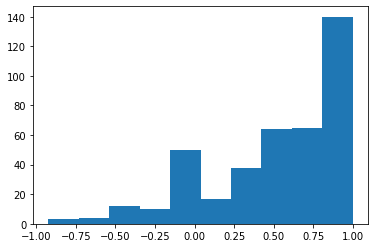

In [64]:
run_mean = np.convolve(df['polarity'],1/402,mode='valid')
length = 400
plt.hist(df['polarity'])